In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, BaggingClassifier,
                              VotingClassifier, StackingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_wdbc_data(filepath='data.csv'):
    """
    Charge le dataset WDBC
    Format attendu: ID, Diagnosis, 30 features
    """
    try:
        # Essayer de charger depuis un fichier local
        df = pd.read_csv(filepath)
    except:
        # Charger depuis sklearn datasets
        from sklearn.datasets import load_breast_cancer
        data = load_breast_cancer()
        df = pd.DataFrame(data.data, columns=data.feature_names)
        df['diagnosis'] = data.target
        # Convertir 0/1 en M/B pour correspondre au format WDBC
        df['diagnosis'] = df['diagnosis'].map({0: 'M', 1: 'B'})
    
    return df

# Charger les données
print("\n[1] Chargement des données...")
df = load_wdbc_data()

print(f"✓ Dataset chargé: {df.shape[0]} échantillons, {df.shape[1]} colonnes")
print(f"\nDistribution des classes:")
print(df['diagnosis'].value_counts())
print(f"\nPourcentages:")
print(df['diagnosis'].value_counts(normalize=True) * 100)


[1] Chargement des données...
✓ Dataset chargé: 569 échantillons, 33 colonnes

Distribution des classes:
diagnosis
B    357
M    212
Name: count, dtype: int64

Pourcentages:
diagnosis
B    62.741652
M    37.258348
Name: proportion, dtype: float64


In [3]:
print("Vérification des valeurs manquantes :\n")
print(df.isnull().sum())

print("\nPourcentage des valeurs manquantes :\n")
print((df.isnull().sum() / len(df)) * 100)

Vérification des valeurs manquantes :

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0


In [9]:
def preprocess_data(df):
    """
    Prétraitement selon l'article:
    1. Séparation features/target
    2. Encodage de la variable cible (M=1, B=0)
    3. Split 70/30 (training/testing)
    4. Standardisation (Z-score normalization)
    """
    
    # Séparer features et target
    
    colonnes_a_supprimer = ['id', 'ID', 'Unnamed: 32']
    df = df.drop(columns=colonnes_a_supprimer, axis=1, errors='ignore')
    
    # Encodage: M (Malin) = 1, B (Bénin) = 0
    y = df['diagnosis'].map({'M': 1, 'B': 0})
    X = df.drop(['diagnosis'], axis=1)
    
    print(f"✓ Features: {X.shape[1]} caractéristiques")
    print(f"✓ Samples: {X.shape[0]} échantillons")
    
    # Split 70/30 (comme dans l'article)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )
    
    print(f"\n✓ Training set: {X_train.shape[0]} échantillons ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"✓ Test set: {X_test.shape[0]} échantillons ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # Standardisation (Z-score normalization)
    # X_standardized = (X - μ) / σ
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    joblib.dump(scaler, "models/scaler.pkl") 
    
    print(f"\n✓ Standardisation appliquée (Z-score normalization)")
    print(f"  Moyenne avant: {X_train.mean().mean():.4f}")
    print(f"  Moyenne après: {X_train_scaled.mean():.4f}")
    print(f"  Std avant: {X_train.std().mean():.4f}")
    print(f"  Std après: {X_train_scaled.std():.4f}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess_data(df)
    

✓ Features: 30 caractéristiques
✓ Samples: 569 échantillons

✓ Training set: 398 échantillons (69.9%)
✓ Test set: 171 échantillons (30.1%)

✓ Standardisation appliquée (Z-score normalization)
  Moyenne avant: 62.0049
  Moyenne après: 0.0000
  Std avant: 34.8269
  Std après: 1.0000


In [10]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """
    Calcule toutes les métriques de performance
    """
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcul des métriques
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # TPR, Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # TNR
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    # FPR et FNR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy * 100,
        'Sensitivity (TPR)': sensitivity * 100,
        'Specificity (TNR)': specificity * 100,
        'Precision': precision * 100,
        'F1-Score': f1 * 100,
        'FPR': fpr * 100,
        'FNR': fnr * 100,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn
    }
    
    # AUC si probabilités disponibles
    if y_pred_proba is not None:
        fpr_curve, tpr_curve, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr_curve, tpr_curve)
        results['AUC-ROC'] = roc_auc * 100
    
    return results

In [11]:
results_list = []

In [12]:
results_list

[]

In [13]:

class LinearRegressionClassifier:
    """
    Régression linéaire utilisée comme classifieur
    Seuil: 0.5 (comme dans l'article)
    """
    def __init__(self):
        self.model = LinearRegression()
        self.threshold = 0.5
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = self.model.predict(X)
        return (predictions >= self.threshold).astype(int)
    
    def predict_proba(self, X):
        predictions = self.model.predict(X)
        # Clip entre 0 et 1 pour simuler des probabilités
        predictions = np.clip(predictions, 0, 1)
        return np.column_stack([1 - predictions, predictions])

lr_clf = LinearRegressionClassifier()
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
y_proba_lr = lr_clf.predict_proba(X_test)[:, 1]

joblib.dump(lr_clf, "models/linear_regression_classifier.pkl") 

results_lr = evaluate_model(y_test, y_pred_lr, y_proba_lr, "Linear Regression")
results_list.append(results_lr)
print(f"✓ Test Accuracy: {results_lr['Accuracy']:.2f}%")

✓ Test Accuracy: 97.66%


In [14]:
mlp = MLPClassifier(
    hidden_layer_sizes=(500, 500, 500),
    activation='relu',
    solver='sgd',
    batch_size=128,
    learning_rate_init=0.001,
    max_iter=3000,
    random_state=42,
    verbose=False
)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]

joblib.dump(mlp, "models/MLPClassifier.pkl") 

results_mlp = evaluate_model(y_test, y_pred_mlp, y_proba_mlp, "MLP")
results_list.append(results_mlp)
print(f"✓ Test Accuracy: {results_mlp['Accuracy']:.2f}%")

✓ Test Accuracy: 98.25%


In [15]:
knn = KNeighborsClassifier(
    n_neighbors=3,
    metric='euclidean',  # L2 norm
    algorithm='auto'
)

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

joblib.dump(knn, "models/KNeighborsClassifier.pkl") 

results_knn = evaluate_model(y_test, y_pred_knn, y_proba_knn, "Nearest Neighbor")
results_list.append(results_knn)
print(f"✓ Test Accuracy: {results_knn['Accuracy']:.2f}%")

✓ Test Accuracy: 95.91%


In [16]:
softmax = LogisticRegression(
    solver='saga',
    max_iter=3000,
    random_state=42,
    verbose=0
)

softmax.fit(X_train, y_train)
y_pred_softmax = softmax.predict(X_test)
y_proba_softmax = softmax.predict_proba(X_test)[:, 1]

joblib.dump(softmax, "models/LogisticRegression_softmax.pkl") 

results_softmax = evaluate_model(y_test, y_pred_softmax, y_proba_softmax, "Softmax Regression")
results_list.append(results_softmax)
print(f"✓ Test Accuracy: {results_softmax['Accuracy']:.2f}%")

✓ Test Accuracy: 97.08%


In [17]:
svm = SVC(
    kernel='linear',
    C=5.0,
    random_state=42,
    probability=True,
    max_iter=3500
)

svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)[:, 1]

joblib.dump(svm, "models/SVM.pkl") 

results_svm = evaluate_model(y_test, y_pred_svm, y_proba_svm, "SVM (Linear)")
results_list.append(results_svm)
print(f"✓ Test Accuracy: {results_svm['Accuracy']:.2f}%")

✓ Test Accuracy: 96.49%



 Entraînement en cours (peut prendre plusieurs minutes)...

 Architecture du modèle:
Model: "GRU_SVM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 reshape_2 (Reshape)         (None, 30, 1)             0         
                                                                 
 gru_layer (GRU)             (None, 256)               198912    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 feature_layer (Dense)       (None, 64)                16448     
                                                                 
 svm_output (Dense)          (None, 1)                 65        
                                       

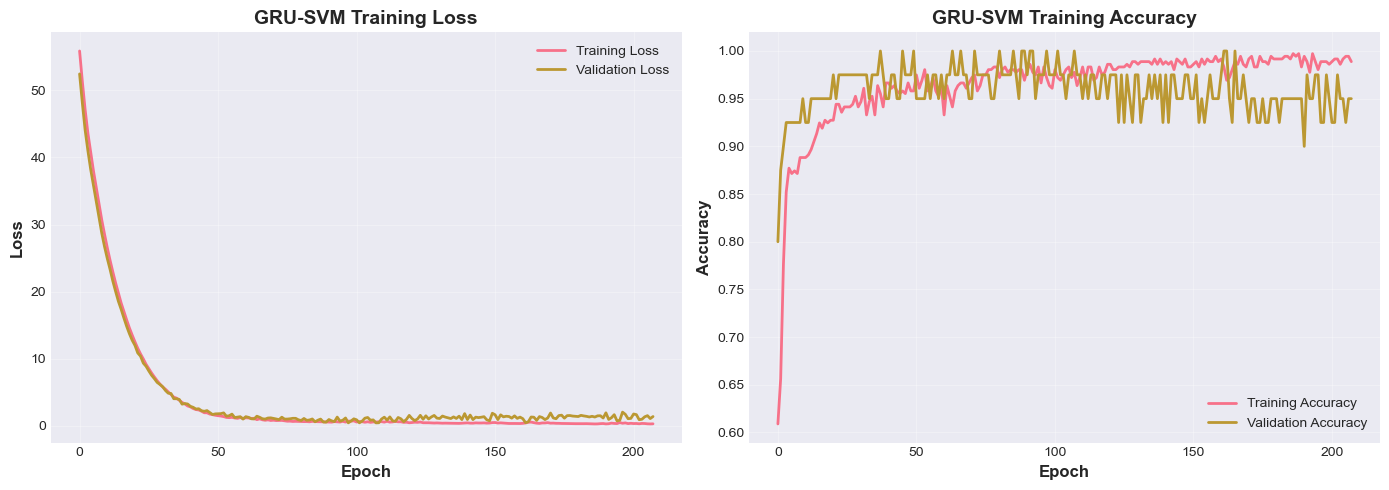

In [20]:

class GRUSVM:
    """
    Modèle hybride GRU-SVM pour classification binaire
    Combine un GRU avec une SVM L2 comme classifieur final
    """
    def __init__(self, input_dim, hidden_units=256, C=5.0, learning_rate=0.001):
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.C = C
        self.learning_rate = learning_rate
        self.model = self._build_model()
        
    def _build_model(self):
        """Construction du modèle GRU-SVM"""
        
        # Input layer - reshape pour GRU (batch, timesteps, features)
        inputs = keras.Input(shape=(self.input_dim,))
        # Ajouter dimension temporelle (considérer chaque feature comme un timestep)
        x = layers.Reshape((self.input_dim, 1))(inputs)
        
        # GRU Layer
        x = layers.GRU(
            units=self.hidden_units,
            activation='tanh',
            recurrent_activation='sigmoid',
            return_sequences=False,  # Retourne seulement le dernier état
            name='gru_layer'
        )(x)
        
        # Dropout pour régularisation
        x = layers.Dropout(0.3)(x)
        
        # Dense layer pour extraire les features
        features = layers.Dense(
            units=64,
            activation='relu',
            name='feature_layer'
        )(x)
        
        # SVM Output Layer - Linear activation pour SVM
        # La fonction de décision SVM: f(x) = w·x + b
        outputs = layers.Dense(
            units=1,
            activation='linear',  # Pas de sigmoid, sortie brute pour SVM
            name='svm_output'
        )(features)
        
        model = keras.Model(inputs=inputs, outputs=outputs, name='GRU_SVM')
        
        return model
    
    def svm_loss(self, y_true, y_pred):
        """
        L2-SVM hinge loss
        """
        # Convertir y_true en float32 AVANT opération
        y_true = tf.cast(y_true, tf.float32)
    
        # Convertir labels en {-1, +1}
        y_true_svm = 2.0 * y_true - 1.0  # y=0 → -1, y=1 → +1
    
        # Hinge loss
        hinge = tf.maximum(0.0, 1.0 - y_true_svm * y_pred)
    
        # L2 squared hinge
        squared_hinge = tf.square(hinge)
    
        # Régularisation L2
        l2_reg = 0.0
        for layer in self.model.layers:
            if hasattr(layer, "kernel"):
                l2_reg += tf.reduce_sum(tf.square(layer.kernel))
    
        # Combine
        loss = 0.5 * l2_reg + self.C * tf.reduce_mean(squared_hinge)
        return loss

    
    def compile_model(self):
        """Compilation avec optimiseur Adam et loss SVM"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss=self.svm_loss,
            metrics=['accuracy']
        )
    
    def fit(self, X_train, y_train, epochs=3000, batch_size=128, validation_split=0.1, verbose=0):
        """Entraînement du modèle"""
        self.compile_model()
        
        # Callbacks
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=100,
            restore_best_weights=True,
            verbose=0
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=50,
            min_lr=1e-6,
            verbose=0
        )
        
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop, reduce_lr],
            verbose=verbose
        )
        
        return history
    
    def predict(self, X):
        """
        Prédiction binaire
        SVM decision: sign(f(x)) -> {-1, +1} puis conversion en {0, 1}
        """
        predictions = self.model.predict(X, verbose=0)
        # Appliquer la fonction de décision: sign(wx + b)
        binary_pred = (predictions > 0).astype(int).flatten()
        return binary_pred
    
    def predict_proba(self, X):
        """
        Pseudo-probabilités pour compatibilité avec sklearn
        Utilise une fonction sigmoïde sur les scores SVM
        """
        scores = self.model.predict(X, verbose=0).flatten()
        # Convertir scores SVM en pseudo-probabilités
        proba_class1 = 1 / (1 + np.exp(-scores))
        proba_class0 = 1 - proba_class1
        return np.column_stack([proba_class0, proba_class1])

# Entraînement du modèle GRU-SVM
print("\n Entraînement en cours (peut prendre plusieurs minutes)...")
start_time = time.time()

# Créer et compiler le modèle
gru_svm = GRUSVM(
    input_dim=X_train.shape[1],
    hidden_units=256,
    C=5.0,
    learning_rate=0.001
)

# Afficher l'architecture
print("\n Architecture du modèle:")
gru_svm.model.summary()

# Entraîner
history_gru = gru_svm.fit(
    X_train, y_train,
    epochs=3000,
    batch_size=128,
    validation_split=0.1,
    verbose=1  # Afficher la progression
)

training_time = time.time() - start_time

# Prédictions
y_pred_gru = gru_svm.predict(X_test)
y_proba_gru = gru_svm.predict_proba(X_test)[:, 1]

# Évaluation
results_gru = evaluate_model(y_test, y_pred_gru, y_proba_gru, "GRU-SVM")
results_list.append(results_gru)

joblib.dump(gru_svm, "models/gru_svm.pkl") 

print(f"\n✓ Test Accuracy: {results_gru['Accuracy']:.2f}%")
print(f"✓ Training time: {training_time//60:.0f}min {training_time%60:.0f}s")
print(f"✓ Final training accuracy: {history_gru.history['accuracy'][-1]*100:.2f}%")

# Visualiser l'historique d'entraînement
fig_history, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history_gru.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history_gru.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('GRU-SVM Training Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy
ax2.plot(history_gru.history['accuracy'], label='Training Accuracy', linewidth=2)
ax2.plot(history_gru.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('GRU-SVM Training Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('gru_svm_training_history.png', dpi=300, bbox_inches='tight')
print("\n✓ Historique d'entraînement sauvegardé: 'gru_svm_training_history.png'")
plt.show()

In [ ]:
results_list


[5] Génération des visualisations...
✓ Graphique sauvegardé: 'model_comparison.png'
✓ Graphique sauvegardé: 'roc_curves.png'


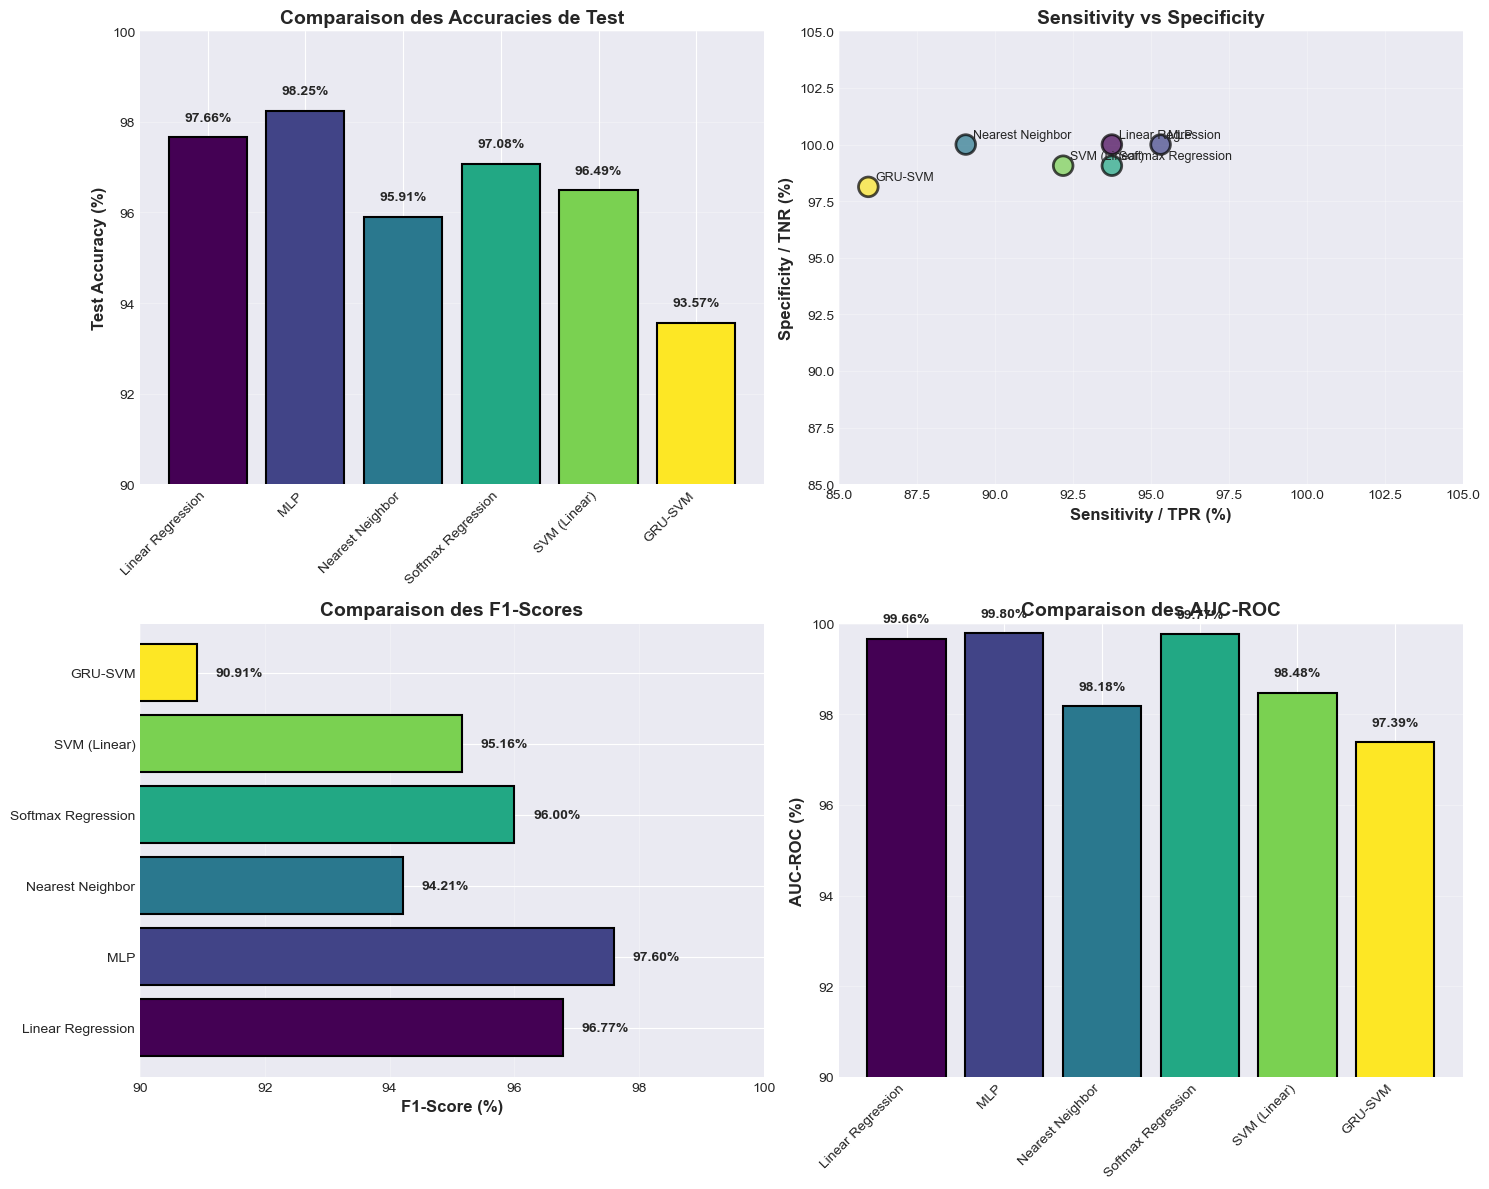

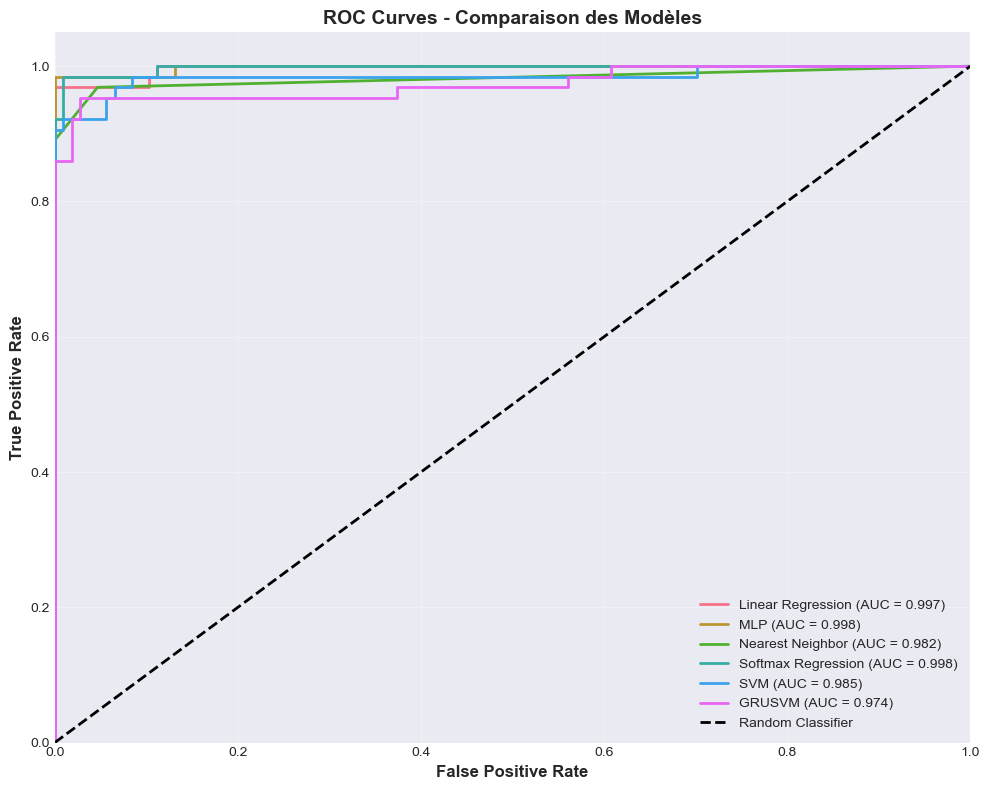

In [19]:
# ============================================================================
# VISUALISATIONS
# ============================================================================

print("\n[5] Génération des visualisations...")

# Figure 1: Comparaison des Accuracies
fig, axes = plt.subplots(2, 2, figsize=(15, 12))


results_list = pd.DataFrame(results_list)

# Subplot 1: Bar plot des accuracies
ax1 = axes[0, 0]
models = results_list['Model']
accuracies = results_list['Accuracy']
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

bars = ax1.bar(range(len(models)), accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Comparaison des Accuracies de Test', fontsize=14, fontweight='bold')
ax1.set_ylim([90, 100])
ax1.grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subplot 2: Sensitivity vs Specificity
ax2 = axes[0, 1]
ax2.scatter(results_list['Sensitivity (TPR)'], results_list['Specificity (TNR)'], 
            s=200, c=colors, edgecolors='black', linewidth=2, alpha=0.7)

for idx, model in enumerate(models):
    ax2.annotate(model, 
                (results_list['Sensitivity (TPR)'].iloc[idx], 
                 results_list['Specificity (TNR)'].iloc[idx]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax2.set_xlabel('Sensitivity / TPR (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Specificity / TNR (%)', fontsize=12, fontweight='bold')
ax2.set_title('Sensitivity vs Specificity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([85, 105])
ax2.set_ylim([85, 105])

# Subplot 3: F1-Score comparison
ax3 = axes[1, 0]
f1_scores = results_list['F1-Score']
bars3 = ax3.barh(range(len(models)), f1_scores, color=colors, edgecolor='black', linewidth=1.5)
ax3.set_yticks(range(len(models)))
ax3.set_yticklabels(models)
ax3.set_xlabel('F1-Score (%)', fontsize=12, fontweight='bold')
ax3.set_title('Comparaison des F1-Scores', fontsize=14, fontweight='bold')
ax3.set_xlim([90, 100])
ax3.grid(axis='x', alpha=0.3)

for bar, f1 in zip(bars3, f1_scores):
    width = bar.get_width()
    ax3.text(width + 0.3, bar.get_y() + bar.get_height()/2.,
             f'{f1:.2f}%', ha='left', va='center', fontsize=10, fontweight='bold')

# Subplot 4: AUC-ROC comparison
ax4 = axes[1, 1]
if 'AUC-ROC' in results_list.columns:
    auc_scores = results_list['AUC-ROC']
    bars4 = ax4.bar(range(len(models)), auc_scores, color=colors, edgecolor='black', linewidth=1.5)
    ax4.set_xticks(range(len(models)))
    ax4.set_xticklabels(models, rotation=45, ha='right')
    ax4.set_ylabel('AUC-ROC (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Comparaison des AUC-ROC', fontsize=14, fontweight='bold')
    ax4.set_ylim([90, 100])
    ax4.grid(axis='y', alpha=0.3)
    
    for bar, auc_val in zip(bars4, auc_scores):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                 f'{auc_val:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé: 'model_comparison.png'")

# Figure 2: ROC Curves
plt.figure(figsize=(10, 8))

models_roc = [
    ("Linear Regression", y_proba_lr),
    ("MLP", y_proba_mlp),
    ("Nearest Neighbor", y_proba_knn),
    ("Softmax Regression", y_proba_softmax),
    ("SVM", y_proba_svm),
    ("GRUSVM", y_proba_gru)
]

for name, proba in models_roc:
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Comparaison des Modèles', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé: 'roc_curves.png'")

plt.show()

In [33]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

results_rf = evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")
results_list.append(results_rf)
print(f"✓ Test Accuracy: {results_rf['Accuracy']:.2f}%")
print(f"✓ Feature importance calculée: {len(rf.feature_importances_)} features")


✓ Test Accuracy: 97.08%
✓ Feature importance calculée: 30 features


In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
    param_grid=param_grid,
import numpy as np


rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)


grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

print("\n🏆 Score CV (F1 macro) :", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)


print("\n📊 Accuracy :", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report :")
print(classification_report(y_test, y_pred))

print("\n🧱 Matrice de confusion :")(
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 864 candidates, totalling 4320 fits
{'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

🏆 Score CV (F1 macro) : 0.9618477678495806

📊 Accuracy : 0.9766081871345029

📄 Classification Report :
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.94      0.97        64

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171


🧱 Matrice de confusion :
[[107   0]
 [  4  60]]


In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False,
    n_jobs=-1
)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_train, y_train)

print("\n🎯 Meilleurs hyperparamètres XGBoost :\n")
print(grid_search_xgb.best_params_)

print("\n🏆 Score CV (F1 macro) :", grid_search_xgb.best_score_)


best_xgb = grid_search_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)

print("\n📊 Accuracy :", accuracy_score(y_test, y_pred_xgb))

print("\n📄 Classification Report :")
print(classification_report(y_test, y_pred_xgb))

print("\n🧱 Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_xgb))


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits

🎯 Meilleurs hyperparamètres XGBoost :

{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}

🏆 Score CV (F1 macro) : 0.9618100750853786

📊 Accuracy : 0.9824561403508771

📄 Classification Report :
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       107
           1       1.00      0.95      0.98        64

    accuracy                           0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171


🧱 Matrice de confusion :
[[107   0]
 [  3  61]]


In [35]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.7,
    colsample_bytree=0.8,
    gamma=0,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

results_xgb = evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")
results_list.append(results_xgb)
print(f"✓ Test Accuracy: {results_xgb['Accuracy']:.2f}%")


✓ Test Accuracy: 98.25%


In [36]:
gb = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

results_gb = evaluate_model(y_test, y_pred_gb, y_proba_gb, "Gradient Boosting")
results_list.append(results_gb)
print(f"✓ Test Accuracy: {results_gb['Accuracy']:.2f}%")


✓ Test Accuracy: 97.08%


In [37]:
gb = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.11],
    'min_samples_split': [3, 4, 6, 8],
    'min_samples_leaf': [1, 3, 4],
    'subsample': [0.6, 0.7, 0.9],
    
}

grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid_gb,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_gb.fit(X_train, y_train)

print("\n Meilleurs hyperparamètres GradientBoostingClassifier :\n")
print(grid_search_gb.best_params_)

print("\n Score CV (F1 macro) :", grid_search_gb.best_score_)


best_gb = grid_search_gb.best_estimator_

y_pred_gb = best_gb.predict(X_test)

print("\n Accuracy :", accuracy_score(y_test, y_pred_gb))

print("\n Classification Report :")
print(classification_report(y_test, y_pred_gb))

print("\n Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_gb))


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits

🎯 Meilleurs hyperparamètres XGBoost :

{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200, 'subsample': 0.7}

🏆 Score CV (F1 macro) : 0.9671477845975739

📊 Accuracy : 0.9649122807017544

📄 Classification Report :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171


🧱 Matrice de confusion :
[[107   0]
 [  6  58]]


In [38]:
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    min_samples_split=6,
    min_samples_leaf=1,
    subsample=0.7,
    random_state=42
)

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

results_gb = evaluate_model(y_test, y_pred_gb, y_proba_gb, "Gradient Boosting")
results_list.append(results_gb)
print(f"✓ Test Accuracy: {results_gb['Accuracy']:.2f}%")


✓ Test Accuracy: 96.49%
